=== Upazila-level (per-day) preview ===
      date  district    upazila_name  risk  aff_p50  aff_p90  water_L_p50  water_L_p90  rations_p50  rations_p90  kits_p50  kits_p90
2025-09-18  Kurigram        Chilmari     3     3000     5000        45000        75000         3000         5000       750      1250
2025-09-18 Sirajganj        Belkuchi     2     3300     5500        49500        82500         3300         5500       825      1375
2025-09-18 Sirajganj         Kazipur     3     4125     6875        61875       103125         4125         6875      1032      1719
2025-09-18 Sirajganj Sirajganj Sadar     3     8250    13750       123750       206250         8250        13750      2063      3438
2025-09-18 Sunamganj           Derai     2     3450     5750        51750        86250         3450         5750       863      1438
2025-09-18 Sunamganj Sunamganj Sadar     3     6000    10000        90000       150000         6000        10000      1500      2500
2025-09-19  Kurigram        C

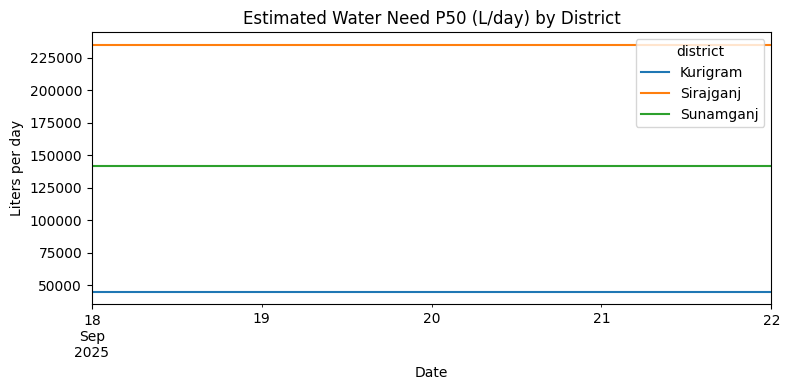

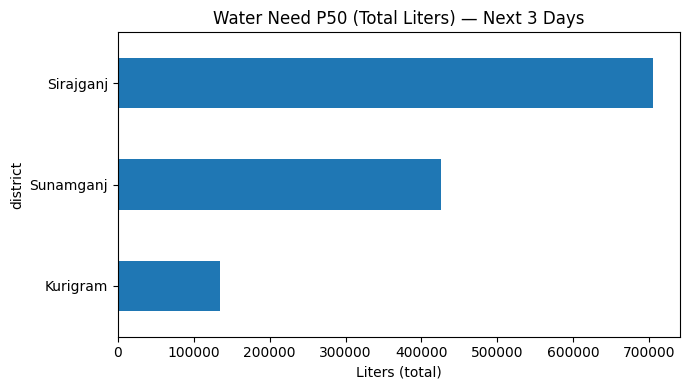

In [3]:
# Flood Relief Planning AI — MVP 
# -----------------------------------------

import os
from pathlib import Path
import pandas as pd
import numpy as np

# ===================== KNOBS (edit here, no code diving) =====================
WATER_PER_PERSON_PER_DAY = 15
RATION_DAYS_PER_PERSON_PER_DAY = 1
HOUSEHOLD_SIZE = 4

# Rain thresholds for risk scoring
THRESH_3DAY = 150   # mm
THRESH_7DAY = 300   # mm

# Planning window (e.g., next 3 days)
PLANNING_DAYS = 3

# Optional: demo randomization to avoid flat plots (set to True for presentations)
DEMO_VARIATION = False
# ============================================================================

DATA_DIR = Path("./")
UPAZILAS_CSV = DATA_DIR / "upazilas.csv"
RAIN_CSV     = DATA_DIR / "rain_forecast.csv"
RIVER_CSV    = DATA_DIR / "river_level.csv"  # not used in MVP

# 0) Ensure templates exist so the notebook always runs
if not UPAZILAS_CSV.exists():
    upazilas_df = pd.DataFrame(
        [
            [101, "Sirajganj Sadar", "Sirajganj", 550_000, 1, "near"],
            [102, "Kazipur",         "Sirajganj", 275_000, 1, "near"],
            [103, "Belkuchi",        "Sirajganj", 220_000, 1, "medium"],
            [201, "Sunamganj Sadar", "Sunamganj", 400_000, 1, "near"],
            [202, "Derai",           "Sunamganj", 230_000, 1, "medium"],
            [301, "Chilmari",        "Kurigram",  200_000, 1, "near"],
        ],
        columns=["upazila_id","upazila_name","district","population","flood_prone_flag","river_proximity_category"]
    )
    upazilas_df.to_csv(UPAZILAS_CSV, index=False)

if not RAIN_CSV.exists():
    dates = pd.date_range("2025-09-18", periods=5, freq="D")
    upa_ids = pd.read_csv(UPAZILAS_CSV)["upazila_id"].tolist()
    rows = []
    for d in dates:
        for upa in upa_ids:
            rows.append([upa, d.strftime("%Y-%m-%d"), 20])  # start with 24h only
    pd.DataFrame(rows, columns=["upazila_id","date","rain_24h"]).to_csv(RAIN_CSV, index=False)

if not RIVER_CSV.exists():
    pd.DataFrame(columns=["station_id","upazila_id","date","river_level","level_anomaly"]).to_csv(RIVER_CSV, index=False)

# 1) Load data
upa = pd.read_csv(UPAZILAS_CSV)
rain = pd.read_csv(RAIN_CSV)
rain["date"] = pd.to_datetime(rain["date"])
upa["flood_prone_flag"] = upa["flood_prone_flag"].astype(int)

# (Optional) add variation to demo charts if your inputs are flat
if DEMO_VARIATION and "rain_24h" in rain.columns:
    np.random.seed(7)
    rain["rain_24h"] = rain["rain_24h"] * (0.8 + 0.4*np.random.rand(len(rain)))

# 1B) Ensure rolling sums exist; auto-compute from rain_24h if needed
rain = rain.sort_values(["upazila_id","date"]).copy()
if "rain_3day_sum" not in rain.columns or "rain_7day_sum" not in rain.columns:
    if "rain_24h" not in rain.columns:
        raise ValueError("Provide either rain_24h or precomputed rain_3day_sum/rain_7day_sum.")
    rain["rain_3day_sum"] = rain.groupby("upazila_id")["rain_24h"].transform(lambda s: s.rolling(3, min_periods=1).sum())
    rain["rain_7day_sum"] = rain.groupby("upazila_id")["rain_24h"].transform(lambda s: s.rolling(7, min_periods=1).sum())

# 2) Merge & sanity checks
df = rain.merge(upa, on="upazila_id", how="left", validate="many_to_one")
assert df["upazila_name"].notna().all(), "Some rain rows did not match any upazila_id. Check your CSVs."

# 3) Risk model (transparent)
def compute_risk(row):
    risk = 0
    if row["rain_3day_sum"] > THRESH_3DAY: risk += 2
    if row["rain_7day_sum"] > THRESH_7DAY: risk += 1
    if row.get("flood_prone_flag", 0) == 1: risk += 2
    if str(row.get("river_proximity_category","")).lower() == "near": risk += 1
    return risk

df["risk"] = df.apply(compute_risk, axis=1)

# 4) Uncertainty bands → people affected (P50/P90)
RISK_TO_PCT = {
    (0,1): (0.004, 0.007),  # 0.4–0.7%
    (2,3): (0.015, 0.025),  # 1.5–2.5%
    (4,5): (0.035, 0.060),  # 3.5–6.0%
    (6,99):(0.080, 0.120),  # 8–12%
}
def pct_band(risk):
    for (lo, hi), (p50, p90) in RISK_TO_PCT.items():
        if lo <= risk <= hi:
            return p50, p90
    return 0.005, 0.010

p = df["risk"].apply(pct_band)
df["pct_p50"] = p.apply(lambda t: t[0])
df["pct_p90"] = p.apply(lambda t: t[1])

df["aff_p50"] = (df["population"] * df["pct_p50"]).round().astype(int)
df["aff_p90"] = (df["population"] * df["pct_p90"]).round().astype(int)

# 5) Convert to commodities (per day, P50/P90)
df["water_L_p50"] = df["aff_p50"] * WATER_PER_PERSON_PER_DAY
df["water_L_p90"] = df["aff_p90"] * WATER_PER_PERSON_PER_DAY
df["rations_p50"] = df["aff_p50"] * RATION_DAYS_PER_PERSON_PER_DAY
df["rations_p90"] = df["aff_p90"] * RATION_DAYS_PER_PERSON_PER_DAY
df["kits_p50"]    = np.ceil(df["aff_p50"]/HOUSEHOLD_SIZE).astype(int)
df["kits_p90"]    = np.ceil(df["aff_p90"]/HOUSEHOLD_SIZE).astype(int)

# 6) Upazila-level planner (per-day)
planner_cols = ["date","district","upazila_name","risk",
                "aff_p50","aff_p90","water_L_p50","water_L_p90","rations_p50","rations_p90","kits_p50","kits_p90"]
planner = df[planner_cols].sort_values(["date","district","upazila_name"]).reset_index(drop=True)

# 7) District totals for planning horizon (sum of next N days)
window_start = df["date"].min()
window_end   = window_start + pd.Timedelta(days=PLANNING_DAYS-1)
win = df[(df["date"] >= window_start) & (df["date"] <= window_end)].copy()

district_totals = (win.groupby("district", as_index=False)
    .agg(
        aff_p50=("aff_p50","sum"),
        aff_p90=("aff_p90","sum"),
        water_L_p50=("water_L_p50","sum"),
        water_L_p90=("water_L_p90","sum"),
        rations_p50=("rations_p50","sum"),
        rations_p90=("rations_p90","sum"),
        kits_p50=("kits_p50","sum"),
        kits_p90=("kits_p90","sum"),
    )
    .sort_values("water_L_p50", ascending=False)
)

print("=== Upazila-level (per-day) preview ===")
print(planner.head(12).to_string(index=False))
print(f"\n=== District totals (next {PLANNING_DAYS} days) preview ===")
print(district_totals.head().to_string(index=False))

# 8) Save outputs
planner_out = DATA_DIR / "planner_upazila_level.csv"
district_out = DATA_DIR / "district_totals_next_N_days.csv"
planner.to_csv(planner_out, index=False)
district_totals.to_csv(district_out, index=False)
print(f"\nSaved: {planner_out.resolve()}")
print(f"Saved: {district_out.resolve()}")

# 9) Quick visuals
try:
    import matplotlib.pyplot as plt

    # Line: water P50 per district over time (daily)
    daily_p50 = (df.groupby(["date","district"], as_index=False)
                   .agg(water_L_p50=("water_L_p50","sum")))
    pivot = daily_p50.pivot(index="date", columns="district", values="water_L_p50")
    ax = pivot.plot(figsize=(8,4), title="Estimated Water Need P50 (L/day) by District")
    plt.xlabel("Date")
    plt.ylabel("Liters per day")
    plt.tight_layout()
    plt.show()

    # Bar: total water for planning horizon (P50)
    tot = district_totals.set_index("district")[["water_L_p50"]].sort_values("water_L_p50")
    ax = tot.plot(kind="barh", figsize=(7,4), legend=False,
                  title=f"Water Need P50 (Total Liters) — Next {PLANNING_DAYS} Days")
    plt.xlabel("Liters (total)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"(Plot skipped) {e}")

# ================= HOW TO USE =================
# - Replace 24h rain in rain_forecast.csv with real forecasts per upazila & day.
# - The script auto-computes 3-day/7-day sums if not provided.
# - Tune THRESH_3DAY / THRESH_7DAY and RISK_TO_PCT ranges after a quick back-test.
# - Hand-pick 5–10 pilot upazilas for a compelling demo.
